In [1]:
%%capture
!pip install gcpds-cv-pykit

In [2]:
import wandb
import torch
import numpy as np
from torch.amp import autocast
import matplotlib.pyplot as plt
from gcpds_cv_pykit.datasets import FeetMamitas
from gcpds_cv_pykit.baseline.dataloaders import Segmentation_DataLoader
from gcpds_cv_pykit.visuals import random_sample_visualization
from gcpds_cv_pykit.baseline.models import UNet, ResUNet, DeepLabV3Plus
from gcpds_cv_pykit.baseline import PerformanceModels

In [3]:
# Set a seed
seed = 42

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [4]:
FeetMamitas()

100%|██████████| 35.4M/35.4M [00:02<00:00, 13.0MB/s]

Extracting files...


Path to downloaded dataset files: /root/.cache/kagglehub/datasets/lucasiturriago/feet-mamitas/versions/3
Dataset copied to: /content/datasets/feet-mamitas
Original folder '/root/.cache/kagglehub/datasets/lucasiturriago/feet-mamitas/versions/3' deleted.


'/content/datasets/feet-mamitas'

In [5]:
config = {"Dir of dataset": "./datasets/feet-mamitas", "Batch size": 36, "Image size": (256,256), "Input size": (3,256,256),
          "Number of classes": 1, "Single class train": None, "Single class test": None, "Single class valid": None, "Images folder": "images",
          "Data augmentation": True, "Epochs": 61, "Device": "cuda:0", "AMixPre": True, "Model": "DeepLabV3+", "Backbone": "resnet34",
          "Pretrained": True, "Activation function": "sigmoid", "Loss function": "DICE", "Save results": True, "Train phases": True,
          "Wandb monitoring": ["5092b6e1a9fb50d7448b32f2db4d0163bb5ef14f","MasterTests","FeetMamitas-DeepLabV3+-DICE"]}

In [6]:
train_dataset = Segmentation_DataLoader(config["Dir of dataset"], config["Batch size"], config["Image size"], config["Number of classes"],
                                        "Train", config["Single class train"], config["Data augmentation"], config["Images folder"])

Searching for images in: datasets/feet-mamitas/Train/images
Supported formats: *.png, *.jpg, *.jpeg
Number of image files found: 248


Organizing masks: 100%|██████████| 248/248 [00:00<00:00, 73882.19it/s]


In [7]:
valid_dataset = Segmentation_DataLoader(config["Dir of dataset"], config["Batch size"], config["Image size"], config["Number of classes"],
                                        "Valid", config["Single class valid"], config["Data augmentation"], config["Images folder"])

Searching for images in: datasets/feet-mamitas/Valid/images
Supported formats: *.png, *.jpg, *.jpeg
Number of image files found: 71


Organizing masks: 100%|██████████| 71/71 [00:00<00:00, 122600.08it/s]


In [8]:
test_dataset = Segmentation_DataLoader(config["Dir of dataset"], config["Batch size"], config["Image size"], config["Number of classes"],
                                        "Test", config["Single class test"], config["Data augmentation"], config["Images folder"])

Searching for images in: datasets/feet-mamitas/Test/images
Supported formats: *.png, *.jpg, *.jpeg
Number of image files found: 35


Organizing masks: 100%|██████████| 35/35 [00:00<00:00, 104187.82it/s]


Images: torch.Size([36, 3, 256, 256]), Masks: torch.Size([36, 1, 256, 256])


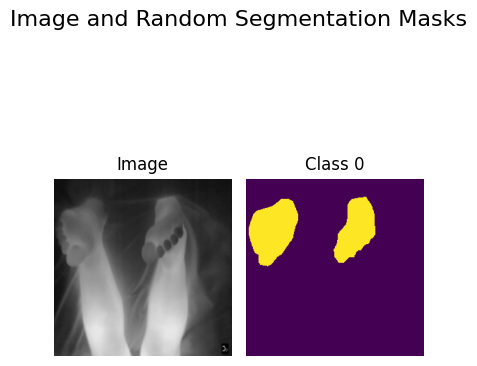

In [9]:
random_sample_visualization(dataset=train_dataset, num_classes=config["Number of classes"],
                            single_class=config['Single class train'],type='baseline')

In [10]:
run = wandb.init()

# UNet model
artifact = run.use_artifact('gcpds/MasterTests/best_model:v58', type='model')
artifact_dir = artifact.download()

# ResUNet model
artifact = run.use_artifact('gcpds/MasterTests/best_model:v49', type='model')
artifact_dir = artifact.download()

# DeepLabV3+ model
artifact = run.use_artifact('gcpds/MasterTests/best_model:v48', type='model')
artifact_dir = artifact.download()

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: liturriago (gcpds) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


wandb: Downloading large artifact 'best_model:v58', 93.60MB. 1 files...
wandb:   1 of 1 files downloaded.  
Done. 00:00:08.6 (10.9MB/s)
wandb: Downloading large artifact 'best_model:v49', 95.64MB. 1 files...
wandb:   1 of 1 files downloaded.  
Done. 00:00:07.7 (12.4MB/s)
wandb: Downloading large artifact 'best_model:v48', 97.71MB. 1 files...
wandb:   1 of 1 files downloaded.  
Done. 00:00:08.3 (11.8MB/s)


In [ ]:
UNet_model = UNet(in_channels=config["Input size"][0],out_channels=config["Number of classes"], final_activation=config["Activation function"])
state_dict = torch.load('/content/artifacts/best_model:v58/best_model.pt', weights_only=True)
UNet_model.load_state_dict(state_dict)
UNet_model.to(torch.device(config.get('Device', 'cpu')))
UNet_model.eval()

In [ ]:
ResUNet_model = ResUNet(in_channels=config["Input size"][0],out_channels=config["Number of classes"], final_activation=config["Activation function"])
state_dict = torch.load('/content/artifacts/best_model:v49/best_model.pt', weights_only=True)
ResUNet_model.load_state_dict(state_dict)
ResUNet_model.to(torch.device(config.get('Device', 'cpu')))
ResUNet_model.eval()

In [ ]:
DeepLabV3Plus_model = DeepLabV3Plus(in_channels=config["Input size"][0],out_channels=config["Number of classes"], final_activation=config["Activation function"])
state_dict = torch.load('/content/artifacts/best_model:v48/best_model.pt', weights_only=True)
DeepLabV3Plus_model.load_state_dict(state_dict)
DeepLabV3Plus_model.to(torch.device(config.get('Device', 'cpu')))
DeepLabV3Plus_model.eval()

In [14]:
images, masks = next(iter(test_dataset))

images = images.to(torch.device(config.get('Device', 'cpu')))
masks = masks.to(torch.device(config.get('Device', 'cpu')))

In [15]:
with torch.no_grad():
  if config.get("AMixPre", False):
      with autocast(torch.device(config.get('Device', 'cpu')).type):
          UNet_pred = UNet_model(images)
          ResUNet_pred = ResUNet_model(images)
          DeepLabV3Plus_pred = DeepLabV3Plus_model(images)
  else:
      FCN_pred = FCN_model(images)
      UNet_pred = UNet_model(images)
      ResUNet_pred = ResUNet_model(images)
      DeepLabV3Plus_pred = DeepLabV3Plus_model(images)

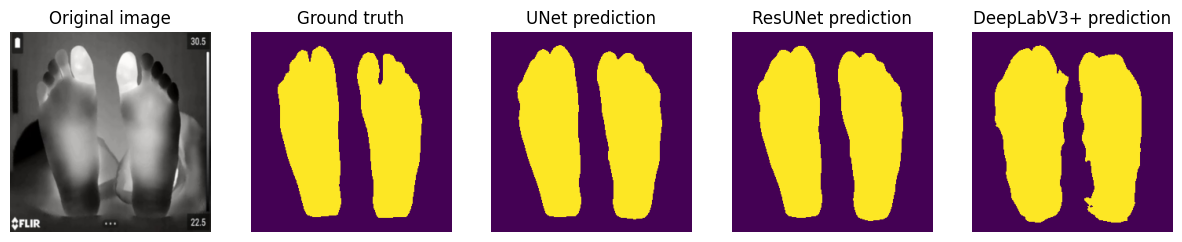

In [16]:
fig, axs = plt.subplots(1, 5, figsize=(15, 15))

sample = 5

axs[0].imshow(images[sample].permute(1, 2, 0).cpu().numpy())
axs[0].set_title('Original image')
axs[0].axis('off')

axs[1].imshow(masks[sample].cpu().numpy()[0])
axs[1].set_title('Ground truth')
axs[1].axis('off')

axs[2].imshow(np.where(UNet_pred[sample].cpu().numpy()[0]>0.5,1,0))
axs[2].set_title('UNet prediction')
axs[2].axis('off')

axs[3].imshow(np.where(ResUNet_pred[sample].cpu().numpy()[0]>0.5,1,0))
axs[3].set_title('ResUNet prediction')
axs[3].axis('off')

axs[4].imshow(np.where(DeepLabV3Plus_pred[sample].cpu().numpy()[0]>0.5,1,0))
axs[4].set_title('DeepLabV3+ prediction')
axs[4].axis('off')

plt.show()